In [1]:
import unicodedata

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

gold_yellow = "#FFC000"

plt.style.use("dark_background")

In [2]:
### PARAMETERS ###

separate_paris = False
check_ = True # whether to print plots

##################

In [3]:
df = gpd.read_file("../data/clean_data.geojson")
df.head()

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,net_salary,population,geometry
0,01004,01,84,882724.0,6542583.0,Ambérieu-en-Bugey,13.7,13460.0,"POLYGON ((5.38637 45.93121, 5.38892 45.93320, ..."
1,01007,01,84,882682.0,6548067.0,Ambronay,13.5,2563.0,"POLYGON ((5.40440 46.00778, 5.39779 46.01009, ..."
2,01014,01,84,906407.0,6580780.0,Arbent,13.5,3281.0,"POLYGON ((5.71332 46.25667, 5.71983 46.25783, ..."
3,01024,01,84,866161.0,6578890.0,Attignat,12.9,3329.0,"POLYGON ((5.16256 46.25622, 5.16464 46.25629, ..."
4,01025,01,84,849782.0,6581485.0,Bâgé-la-Ville,13.0,3142.0,"POLYGON ((4.92091 46.30781, 4.92544 46.31070, ..."


In [4]:
def normalize(text):
    nfkd_form = unicodedata.normalize("NFKD", text)
    text = nfkd_form.encode("ASCII", "ignore").decode("ASCII")
    text = text.lower().replace(" ", "_").replace("-", "").replace(" ", "").replace("''", "")
    return text

def distance(pos1, pos2):
    # print(pos1.shape),print(pos2.shape)
    (x1, y1), (x2, y2) = pos1.T / 1000, pos2/ 1000
    
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1 - y2, 2))



In [5]:
metropolis = [
    "Paris", "Lyon", "Marseille", "Angers","Avignon","Besançon","Bordeaux","Brest",
    "Caen","Clermont-Ferrand","Dijon","Grenoble","Le Havre","Le Mans","Lille", 
    "Montpellier","Mulhouse","Nancy","Nantes","Nice","Orléans","Reims",
    "Rouen","Saint-Étienne","Strasbourg","Toulouse","Tours","Rennes", 
     "Limoges", "Cherbourg-Octeville", "Poitiers", "Pau", "Lorient", "Saint-Brieuc", 
    #"Chartres"
]

metropolis = sorted(list(set(metropolis)))
print(len(metropolis))

print(metropolis)

34
['Angers', 'Avignon', 'Besançon', 'Bordeaux', 'Brest', 'Caen', 'Cherbourg-Octeville', 'Clermont-Ferrand', 'Dijon', 'Grenoble', 'Le Havre', 'Le Mans', 'Lille', 'Limoges', 'Lorient', 'Lyon', 'Marseille', 'Montpellier', 'Mulhouse', 'Nancy', 'Nantes', 'Nice', 'Orléans', 'Paris', 'Pau', 'Poitiers', 'Reims', 'Rennes', 'Rouen', 'Saint-Brieuc', 'Saint-Étienne', 'Strasbourg', 'Toulouse', 'Tours']


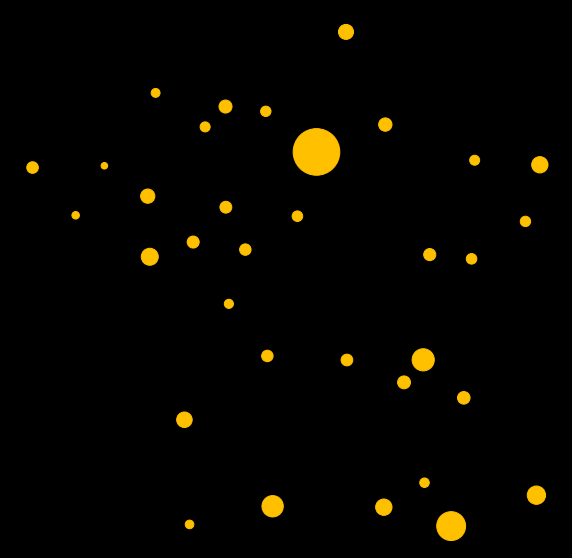

In [6]:
if check_:
    df_temp = df[df["libgeo"].isin(metropolis)]

    plt.figure(figsize=(10, 10))
    plt.scatter(
        df_temp["xcl2154"],
        df_temp["ycl2154"],
        s=df_temp["population"] / 1000,
        color=gold_yellow
    )
    plt.axis("off")
    plt.show()

In [7]:
for m in tqdm(sorted(metropolis)):
    m_position = df[["xcl2154", "ycl2154"]][df["libgeo"] == m].values[0]
    df[f"distance_to_{normalize(m)}"] = distance(df[["xcl2154", "ycl2154"]].values, m_position)

100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 308.26it/s]


In [8]:
df.isna().sum().sum()

0

In [9]:
df["dist_min"] = df[[c for c in df.columns if "distance_to_" == c[:12]]].min(axis=1)

df["closest_metropolis"] = np.argmin(df[[c for c in df.columns if "distance_to_" == c[:12]]].values, axis=1)

df["closest_metropolis"] = df["closest_metropolis"].apply(lambda i: metropolis[i])

In [10]:
if separate_paris:
    def paris_separation(x, y, x_paris=652492.0, y_paris=6862009.0):
        x_delta = x - x_paris
        y_delta = y - y_paris

        angle = np.arctan2(y_delta, x_delta)
        return (angle < -np.pi * 3 / 4) | (angle > np.pi * 3/4)

    df = df.dropna()

    df.loc[(df["closest_metropolis"] == "Paris") & (paris_separation(df["xcl2154"], df["ycl2154"])), "closest_metropolis"] = "Paris - West"
    df.loc[(df["closest_metropolis"] == "Paris") & (-paris_separation(df["xcl2154"], df["ycl2154"])), "closest_metropolis"] = "Paris"


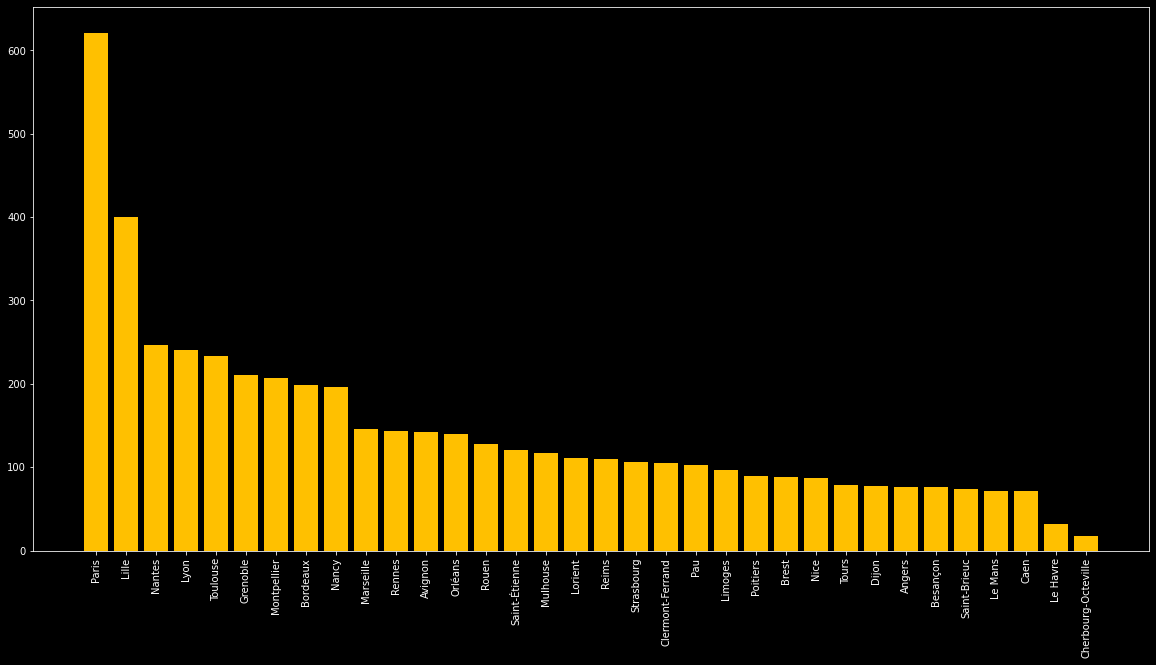

In [11]:
if check_:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    city_check = df["closest_metropolis"].value_counts()
    plt.bar(range(len(city_check)), city_check, color=gold_yellow)
    plt.xticks(range(len(city_check)), city_check.index, rotation=90)
    

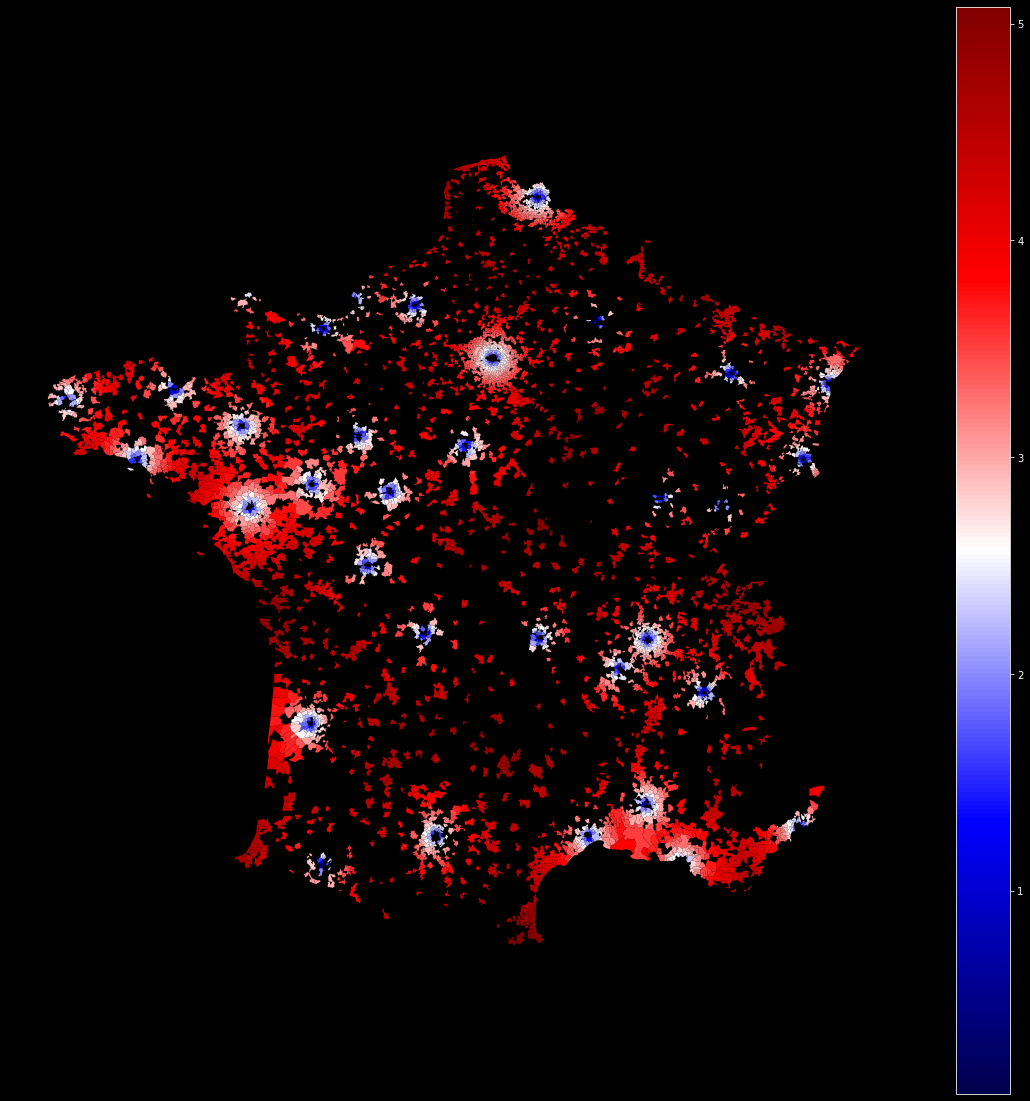

In [13]:
if check_:
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    
    df_temp = df[df["dist_min"] > 0]
    
    df_temp.plot(
        np.log(df_temp["dist_min"]),
        cmap="seismic",
        legend=True,
        ax=ax
    )
    
    ax.axis("off")
    plt.savefig("../images/map_dist_min.png")
    
    

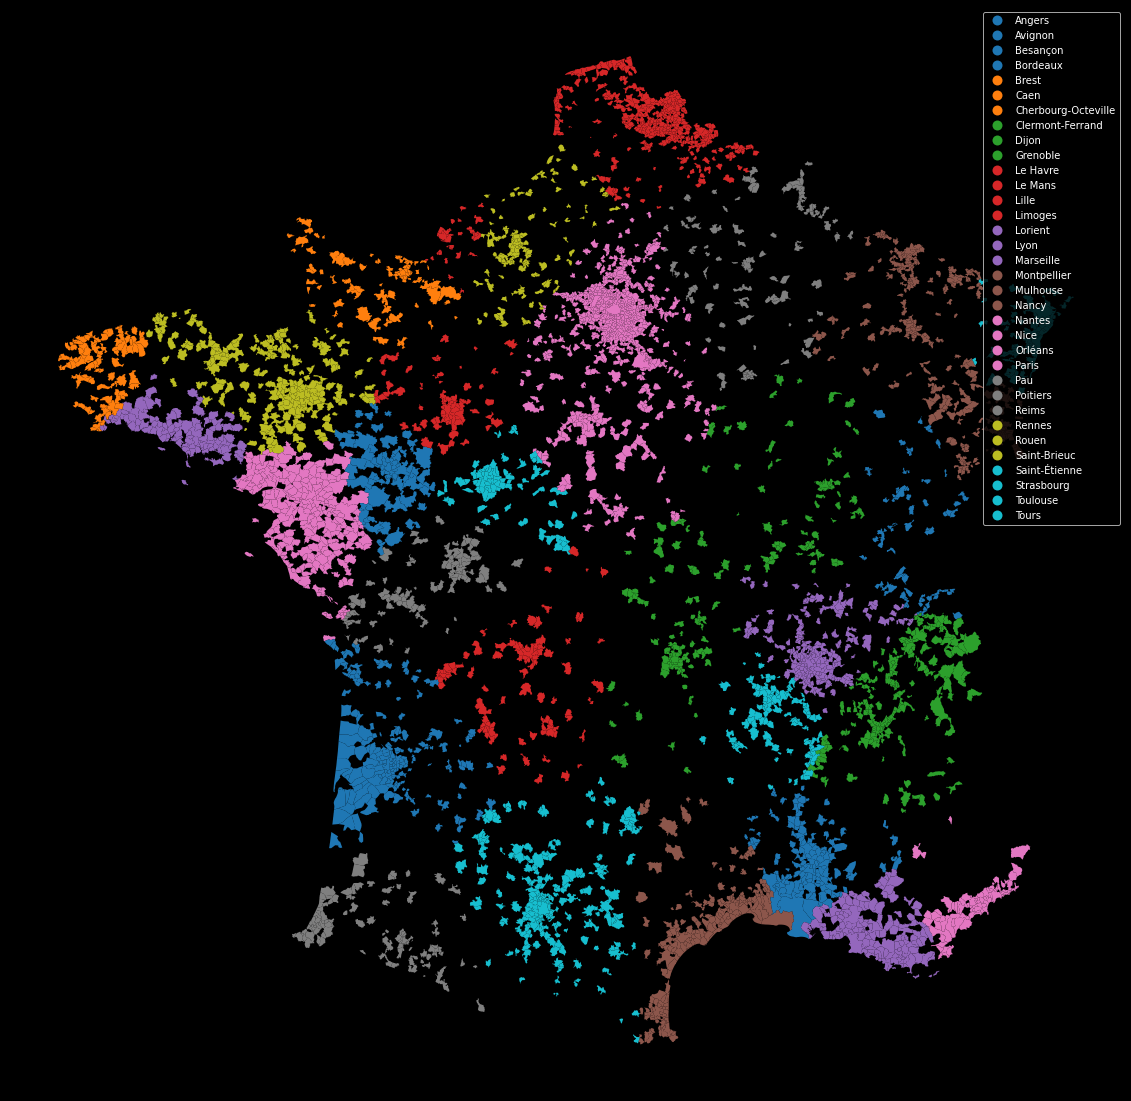

In [14]:
if check_:
    df_temp = df
    
    fig, ax = plt.subplots(1, 1, figsize=(24, 20))
    
    df_temp.plot(
        df_temp["closest_metropolis"],
        legend=True,
        ax=ax
    )
    ax.axis("off")
    plt.savefig("../images/map_metropolis.png")

In [14]:
df.to_file("../data/master.geojson")

/home/paul/.local/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
